In [1]:
%matplotlib inline
from pynq import Overlay
from pynq import MMIO
from pynq.lib import AxiGPIO
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
GPIO = Overlay('AD7606PLSPI.bit')

miner0[0:3] -- OS0[0:3]
miner0[3]  --  RST

miner1[0:2] -- STA, STB
miner1[2]  --  BUSY

miner2[0] -- clk
miner2[1:3]-- db78
miner2[3] -- cs

In [3]:
miner_instance_0 = GPIO.ip_dict["plMiner0"]
miner_instance_1 = GPIO.ip_dict["plMiner1"]
SPI_regSpace = GPIO.ip_dict["AD7606"]
miner0 = AxiGPIO(miner_instance_0).channel1  # 数字滤波器， 复位
miner1 = AxiGPIO(miner_instance_1).channel1  # 转换控制， busy
IP_BASE_ADDRESS = SPI_regSpace['phys_addr']
IP_ADDRESS_RNGE = SPI_regSpace['addr_range']
AxiQspi = MMIO(IP_BASE_ADDRESS, IP_ADDRESS_RNGE)

In [4]:
XSP_DGIER_OFFSET = 0x1C
XSP_IISR_OFFSET = 0x20
XSP_IIER_OFFSET = 0x28
XSP_SRR_OFFSET = 0x40
XSP_CR_OFFSET = 0x60
XSP_SR_OFFSET = 0x64
XSP_DTR_OFFSET = 0x68
XSP_DRR_OFFSET = 0x6C
XSP_SSR_OFFSET = 0x70
XSP_TFO_OFFSET = 0x74
XSP_RFO_OFFSET = 0x78
XSP_REGISTERS = [0x40, 0x60, 0x64, 0x68, 0x6c, 0x70, 0x74, 0x78, 0x1c, 0x20, 0x28]

XSP_SRR_RESET_MASK = 0x0A
XSP_SR_TX_EMPTY_MASK = 0x00000004
XSP_SR_TX_FULL_MASK	= 0x00000008
XSP_CR_TRANS_INHIBIT_MASK = 0x00000100
XSP_CR_LOOPBACK_MASK	= 0x00000001
XSP_CR_ENABLE_MASK	= 0x00000002
XSP_CR_MASTER_MODE_MASK	= 0x00000004
XSP_CR_CLK_POLARITY_MASK = 0x00000008
XSP_CR_CLK_PHASE_MASK	= 0x00000010
XSP_CR_TXFIFO_RESET_MASK = 0x00000020
XSP_CR_RXFIFO_RESET_MASK = 0x00000040
XSP_CR_MANUAL_SS_MASK	= 0x00000080
XSP_CR_TRANS_INHIBIT_MASK = 0x00000100

SLAVE_NO_SELECTION = 0xFFFFFFFF

In [5]:
def cnfg(AxiQspi, clk_phase=0, clk_pol=0):
	print("Configure device")
	AxiQspi.write(XSP_SRR_OFFSET, XSP_SRR_RESET_MASK)
	AxiQspi.write(XSP_DGIER_OFFSET, 0)
	AxiQspi.write(XSP_SSR_OFFSET, SLAVE_NO_SELECTION)
	ControlReg = AxiQspi.read(XSP_CR_OFFSET)
	ControlReg = ControlReg | XSP_CR_MASTER_MODE_MASK | XSP_CR_MANUAL_SS_MASK | XSP_CR_ENABLE_MASK
	AxiQspi.write(XSP_CR_OFFSET, ControlReg)
	ControlReg = AxiQspi.read(XSP_CR_OFFSET)
	if clk_phase == 1:
		ControlReg = ControlReg | XSP_CR_CLK_PHASE_MASK
	else:
		ControlReg = ControlReg & ~XSP_CR_CLK_PHASE_MASK
	if clk_pol == 1:
		ControlReg = ControlReg | XSP_CR_CLK_POLARITY_MASK
	else:
		ControlReg = ControlReg & ~XSP_CR_CLK_POLARITY_MASK
	AxiQspi.write(XSP_CR_OFFSET, ControlReg)

	return 0

In [6]:
def xfer(packet, AxiQspi):
# 	print("TransferData")
	for data in packet:
		AxiQspi.write(XSP_DTR_OFFSET, data)
		AxiQspi.write(XSP_SSR_OFFSET, 0xFFFFFFFE)
		ControlReg = AxiQspi.read(XSP_CR_OFFSET)
		ControlReg = ControlReg & ~XSP_CR_TRANS_INHIBIT_MASK
		AxiQspi.write(XSP_CR_OFFSET, ControlReg)
		
		StatusReg = AxiQspi.read(XSP_SR_OFFSET)
		while (StatusReg & XSP_SR_TX_EMPTY_MASK) == 0:
			StatusReg = AxiQspi.read(XSP_SR_OFFSET)

# 		print('XSP_RFO_OFFSET  : 0x{0:08x}'.format(AxiQspi.read(XSP_RFO_OFFSET)))
		ControlReg = AxiQspi.read(XSP_CR_OFFSET)
		ControlReg = ControlReg | XSP_CR_TRANS_INHIBIT_MASK
		AxiQspi.write(XSP_CR_OFFSET, ControlReg)

	AxiQspi.write(XSP_SSR_OFFSET, SLAVE_NO_SELECTION)
	
# 	print("ReadResponse")
	resp = list()
	RxFifoStatus = AxiQspi.read(XSP_SR_OFFSET) & 0x01
	while RxFifoStatus == 0:
		temp = AxiQspi.read(XSP_RFO_OFFSET)
# 		print('XSP_RFO_OFFSET  : 0x{0:08x}'.format(temp))
		temp = AxiQspi.read(XSP_DRR_OFFSET)
# 		print('XSP_DRR_OFFSET  : 0x{0:08x}'.format(temp))    
		resp.append(temp)
		RxFifoStatus = AxiQspi.read(XSP_SR_OFFSET) & 0x01
	
	return resp

In [7]:
def GPIOreset(val = 0xff):
    if val == 0:
        miner0.trimask = 0xf;
    elif val == 1:
        miner1.trimask = 0xf;
    else:
        miner0.trimask = 0xf;
        miner1.trimask = 0xf;

In [8]:
def AD7606_SETOS(val = 0x00):  # 数字滤波器设置
    miner0[0:3].write(val & 0x7)

In [9]:
def AD7606_RESET():  # 重置AD7606
    miner0[3].on()
    time.sleep(0.05)
    miner0[3].off()

In [10]:
def AD7606_BUSY():  # 获取是否正在转换
    status = (miner1.read() & 0x04)
#     status = np.bitwise_and(miner1.read(), 0x04)
    return status

In [11]:
def AD7606_STARTCONV():  # 开始转换指令
    miner1[0:2].off()
#     time.sleep(0.0001)
    miner1[0:2].on()

In [12]:
def AD7606_FREEZECONV():  # 拉高待机
    miner1[0:2].on()

In [13]:
GPIOreset()  # 恢复所有端口为高阻
AD7606_SETOS(0x00)
AD7606_RESET()
AD7606_FREEZECONV()
cnfg(AxiQspi)

Configure device


0

In [14]:
data = np.zeros((8, 100))

# 测试  
AD7606_STARTCONV()  
while AD7606_BUSY():  
        pass  
for i in range(8):  
    AD7606_CS_L()  
    tmp = ad7606_ReadBytes()  
    AD7606_CS_H()  
    print(tmp)  

In [15]:
time_start = time.time()
for k in range(100):  # 采集100个点
    AD7606_STARTCONV()
    while AD7606_BUSY():
        pass
    res = xfer([0, 0, 0, 0, 0, 0, 0, 0], AxiQspi)
    data[:, k] = np.array(res)
totalTime = time.time() - time_start
print(f"耗时{totalTime}秒")

耗时0.25084710121154785秒


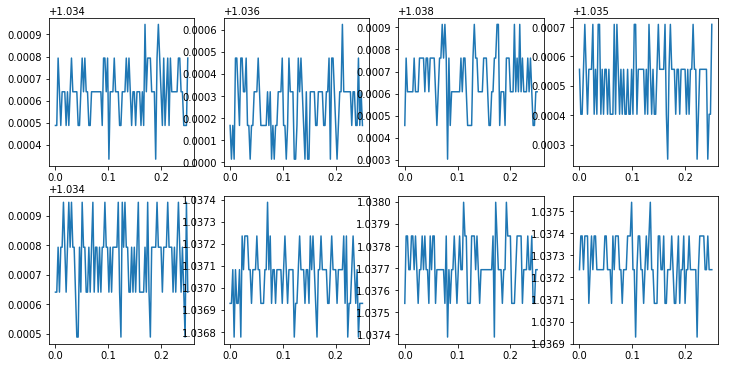

In [16]:
t = np.linspace(0,totalTime,100)
data = data / 6553
canvas = plt.gcf()
canvas.set_size_inches((12,6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.plot(t, data[i, :])
plt.show()